In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

## Setting Up Shakespeare Dataset

This TinyShakespeare dataset is the collection of all of Shakespeare's works, which is about 1M characters

In [4]:
lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])
#print(vocab)

First Citizen:
Before we proce


## Setting Up a Simple Charecter Level Tokenizer

Although LLaMA is trained using the SentencePiece byte-pair encoding tokenizer, for our purposes of character-level modeling, we will use a simpler character-level tokenization approach.

In [8]:
def encode(s):
    return [stoi[ch] for ch in s]

def decode(s):
    return ''.join([itos[i] for i in s])

print('vocab size:', len(vocab))
decode(encode("Yolo"))

vocab size: 65


'Yolo'

Given the small size of our dataset, we don’t need to be concerned about memory management or storage optimizations.

In [11]:
# object to store all model parameter details
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    'batch_size': 8,
    'context_window': 16,
    'd_model': 128
}

In [12]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])


Let's create a function to generate training data and labels in batches, which we'll also reuse for validation and test sets.

In [13]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

In [12]:
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('uts well forth: ', 'ts well forth: p'),
 ('e that time it i', ' that time it is'),
 ('ever thou wast b', 'ver thou wast bo'),
 ('d humbly bend th', ' humbly bend thy'),
 (', you, Sir Willi', ' you, Sir Willia'),
 (' summer fields a', 'summer fields an'),
 ('ne!\n\nKING EDWARD', 'e!\n\nKING EDWARD '),
 ('ength in grief;\n', 'ngth in grief;\nO')]

## Setting up Base Model
A basic feed forward model with embeddings

In [14]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

## Setting up Model Eval

In [15]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [19]:
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
print(loss)

model params: 33217
tensor(4.1747, grad_fn=<NllLossBackward0>)


Here we get a loss of 4.174 which is equivalent of -ln(1/65) Here 65 is the vocab size. So our loss is expected. At this stage, we need to pay close attention to the shape of our tensors and ensure that the indices are properly aligned.

model params: 33217
validation loss:  3.9279476165771485


<Axes: >

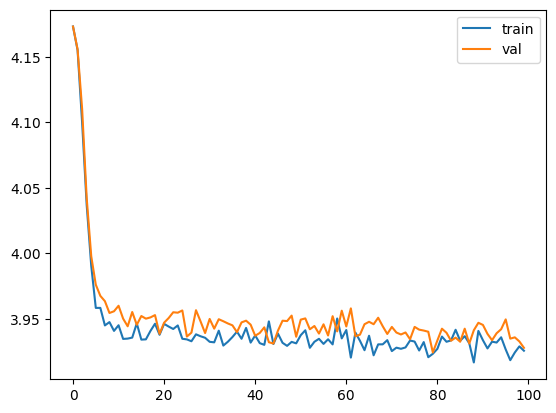

In [20]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

Notice that our model currently applies a softmax layer to the logits, which converts the output into a probability distribution. However, when using PyTorch's `F.cross_entropy` function, it expects the raw, unnormalized logits. Therefore, we'll remove the softmax layer from our model and rerun it.

model params: 33217
validation loss:  2.5256400108337402


<Axes: >

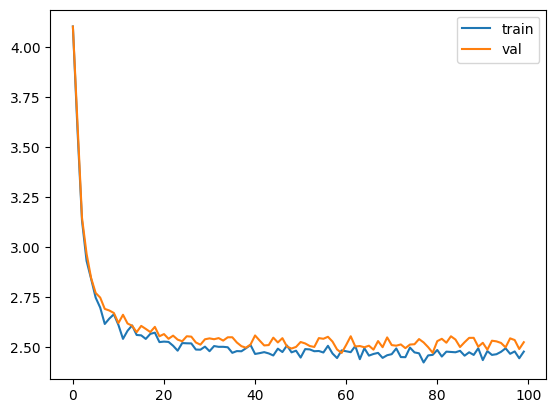

In [21]:
class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Great! Our loss is now 2.52, significantly improved from the initial choosing of 65 charecters, and we're working with 12.67 characters. Let's add a generation method to our model to visually evaluate its results.

In [22]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\nWh it w ted bug y foll.\nG ts: ',
 '\n\nWhe?\nTheat at tobr hie or tha',
 '\nARCORifincour.\nYONGo s wh jes ',
 '\nWalyetutho My! we oroveantous ',
 "\n\n\n\n\nSureid's who, Yotheishees "]

We now have a working model that is converging on a validation loss, so we can iterate to bring it closer to LLaMA's performance.

## LLaMA Specifications

LLaMA introduces three architectural modifications to the original Transformer:

- RMSNorm for Pre-Normalization
- Rotary Embeddings
- SwiGLU Activation Function

We'll implement these modifications one at a time to our base model and refine it.

## RMSNorm

In the original Transformer by Vaswani (2017), Batch Normalization is used. LLaMA, however, employs RMSNorm, which scales the vector by its variance without centering it. Additionally, while Vaswani applies normalization after the attention layer (post-normalization), LLaMA applies it to the inputs beforehand (pre-normalization).

In [23]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}

In [24]:
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


In [25]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)

# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

Alright, so that's RMSNorm, and it seems like it's working. Again, let's test it out.

In [26]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 35265
validation loss:  2.513310170173645


<Axes: >

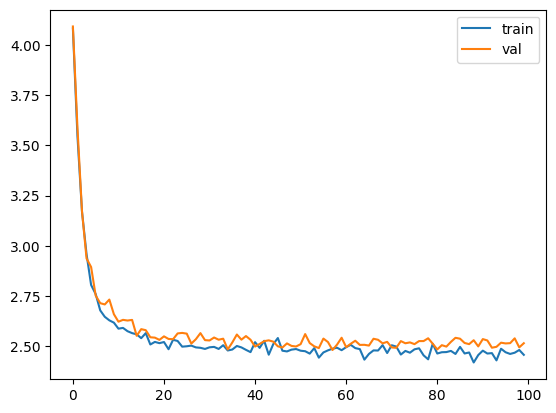

In [27]:
model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

## Rotary Embeddings
RoPE is a kind of positional encoding for transformers. In Attention is All You Need, the authors propose two kinds of positional encodings, learned and fixed. In RoPE, the authors propose embedding the position of a token in a sequence by rotating the embedding, with a different rotation at each position.

In [28]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

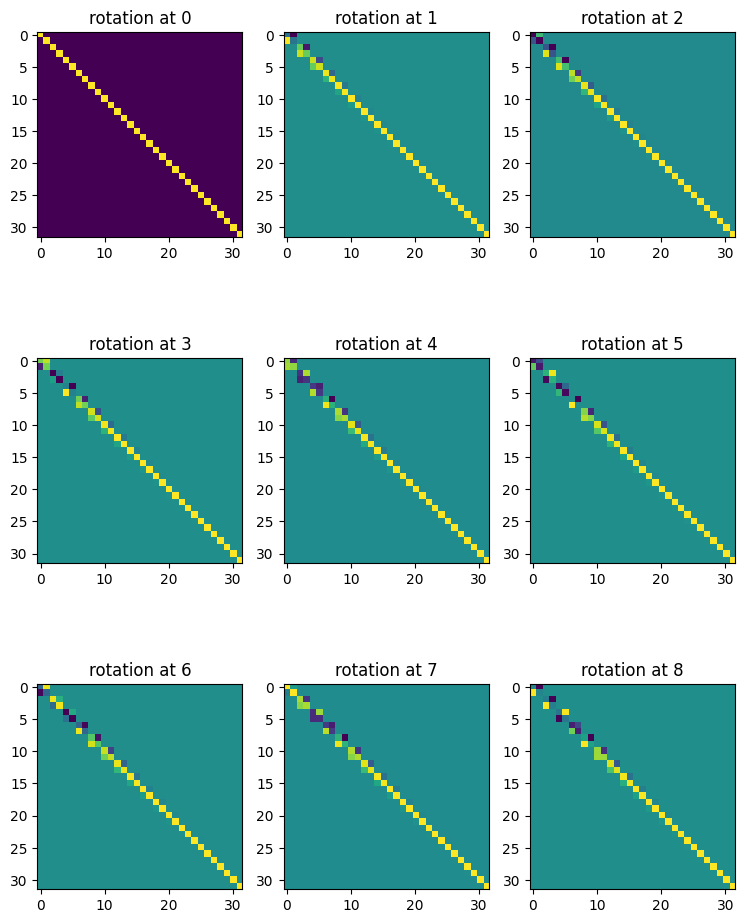

In [29]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [30]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

In [31]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1
        )

        if return_attn_weights:
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

In [32]:
layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [33]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_rotated = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_rotated = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_rotated)

In [35]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttentionHead(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

C:\Users\krish\AppData\Local\Temp\ipykernel_16060\2062321511.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  assert q.T @ k == q @ k # transpose is redundant


In [34]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x
    
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

model params: 559681
validation loss:  0.16116756796836854


<Axes: >

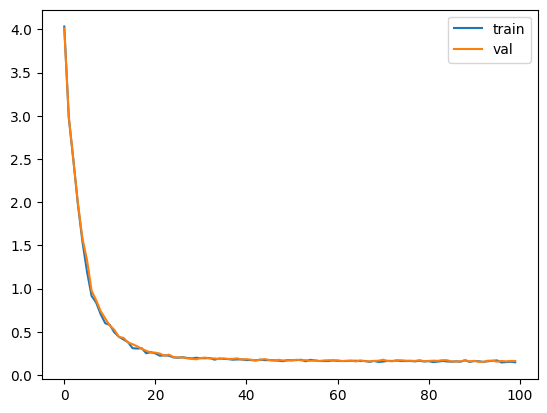

In [35]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [36]:
generate(model, config=MASTER_CONFIG)

['\nUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU',
 '\n\n\nUUUUUUUUUUUUUUUUUUUUUUUUUUUU',
 '\n\nUUUUUUUUUUUUUUUUUUUUUUUUUUUUU',
 '\n\n\n\nUUUUUUUUUUUUUUUUUUUUUUUUUUU',
 '\n\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']

So it looks terrible. What is happening here? Let's start debugging this by looking at the attention.

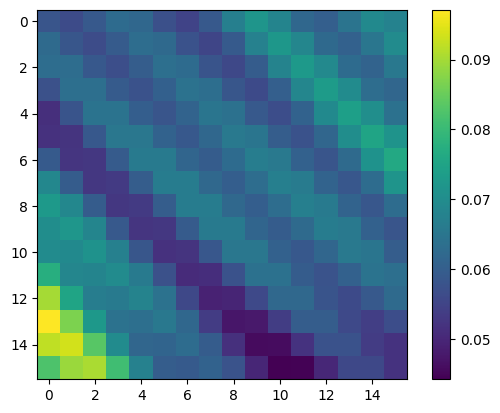

In [37]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()

So here we see that all the attention is lit up, meaning that characters in any position are attending to characters in any other position. What's bad about this? We are trying to predict the next token solely on the tokens that came before it, but here we're seeing that the model is attending to tokens that come after it. In other words, the model is cheating, or leaking information from the future. This is a problem, and it's why we need to use a causal mask.

In [38]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEMaskedAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

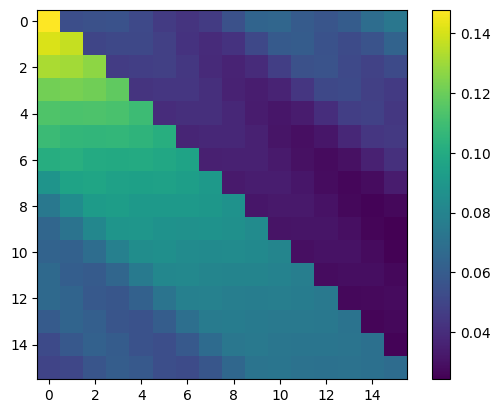

In [39]:
layer = RoPEMaskedAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [40]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x
    
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

In [41]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

model params: 559681


Much better, our loss is now not merely dropping to near-zero. It looks like we can drive our loss down even lower. Let's do that by updating master config.

validation loss:  1.9227156519889832


<Axes: >

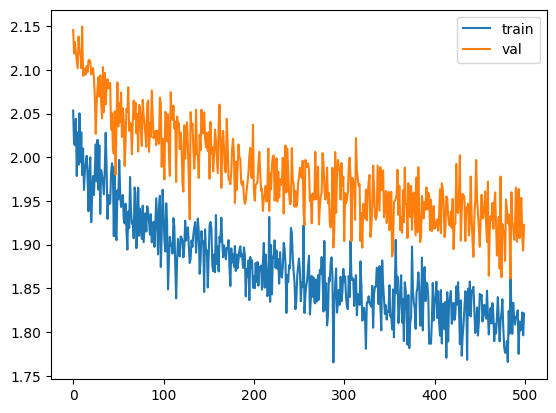

In [44]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer)